In this scrip, we are using the models trained in the last script in new data, with the objective of obtaing detected bounding boxes (annotations).

# 5.1 Check wich model performed best

In COMET, we take a look at the graphs and generate new ones to look into the accuracy (metrics/mAP5095(B))

## 5.1.1. Models trained with my annotations

From the models trained with my dataset, the best ones according to mAP50(B) were peaceful_weed_8422 and bald_balackberry_5816, which corresponds to a YOLO Large and image size of 608 and a YOLO Nano with image size of 800.

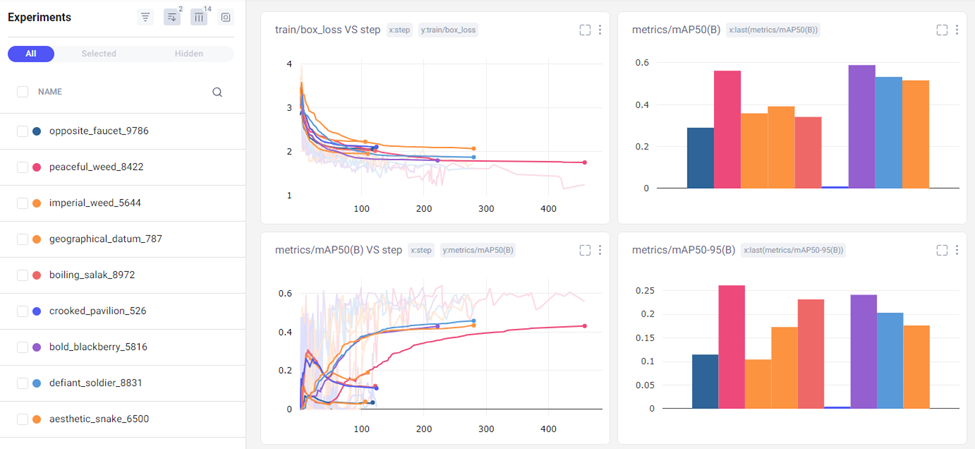

Since both models achieved similar mAP50(B) values, YOLO Nano less resource constraint, which allows to mount it in smaller devices and could be used in real-time scenarios, I am going to select the **YOLO Nano with an image size of 800** for further analysis.



Also, is helpful to look at the graphics generated, like the precision-recall graphic, which the look a bit odd but still shows a good trend.

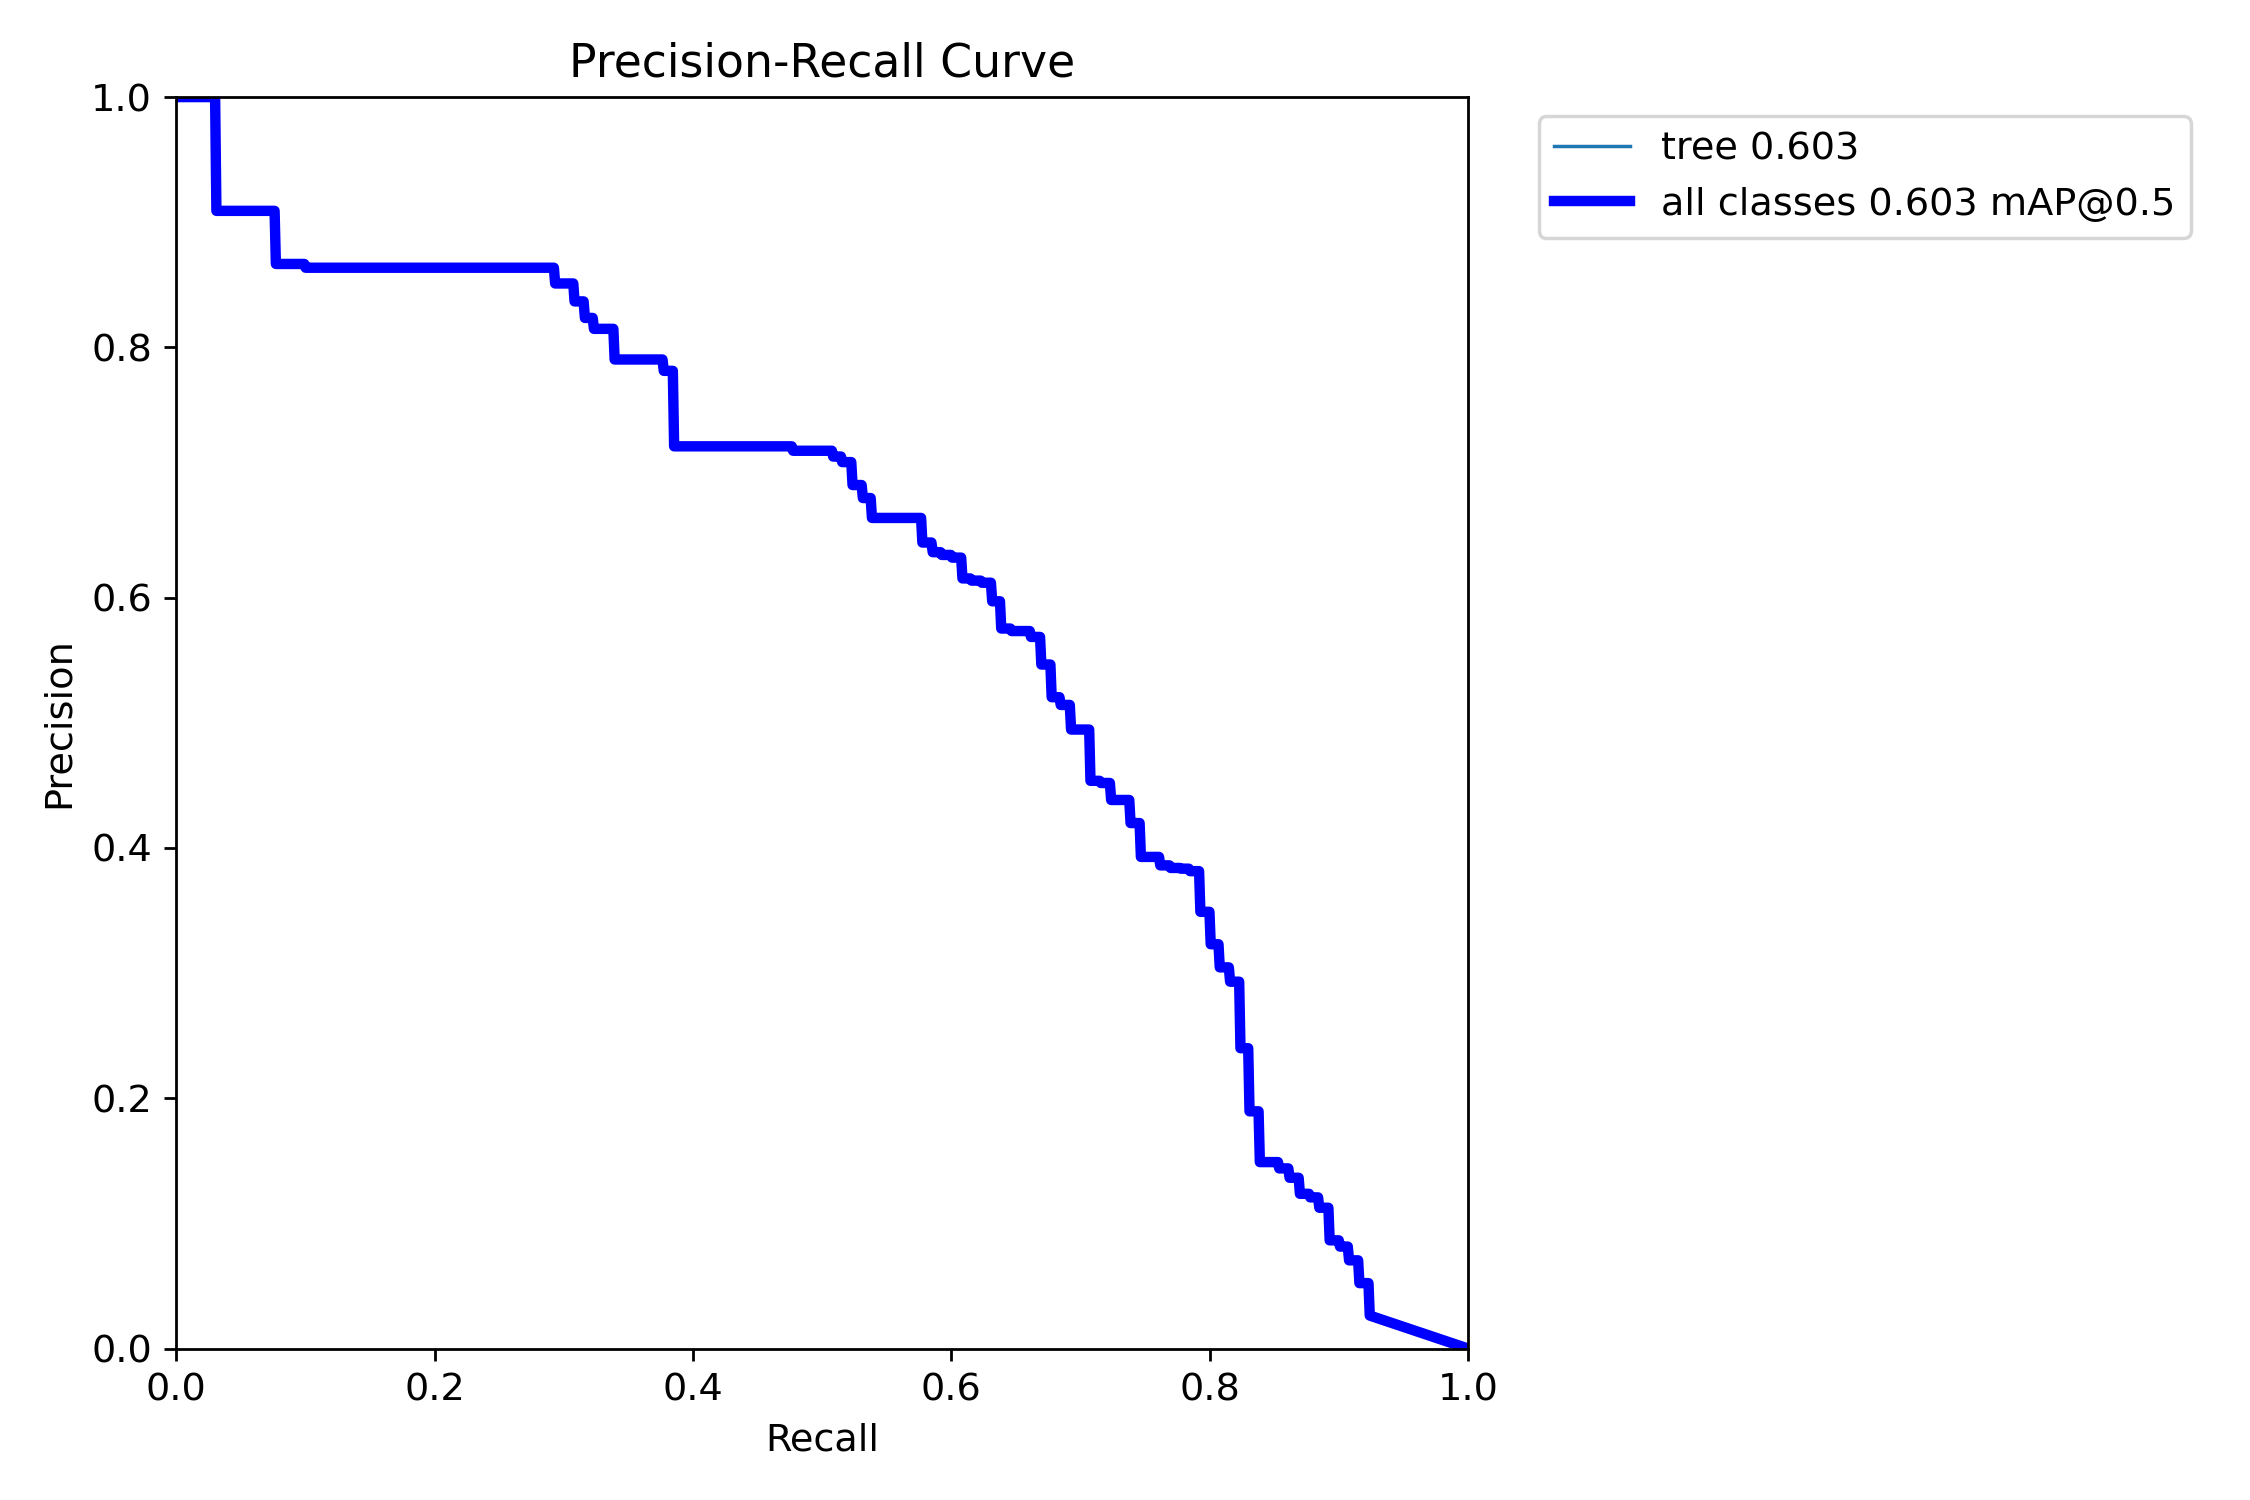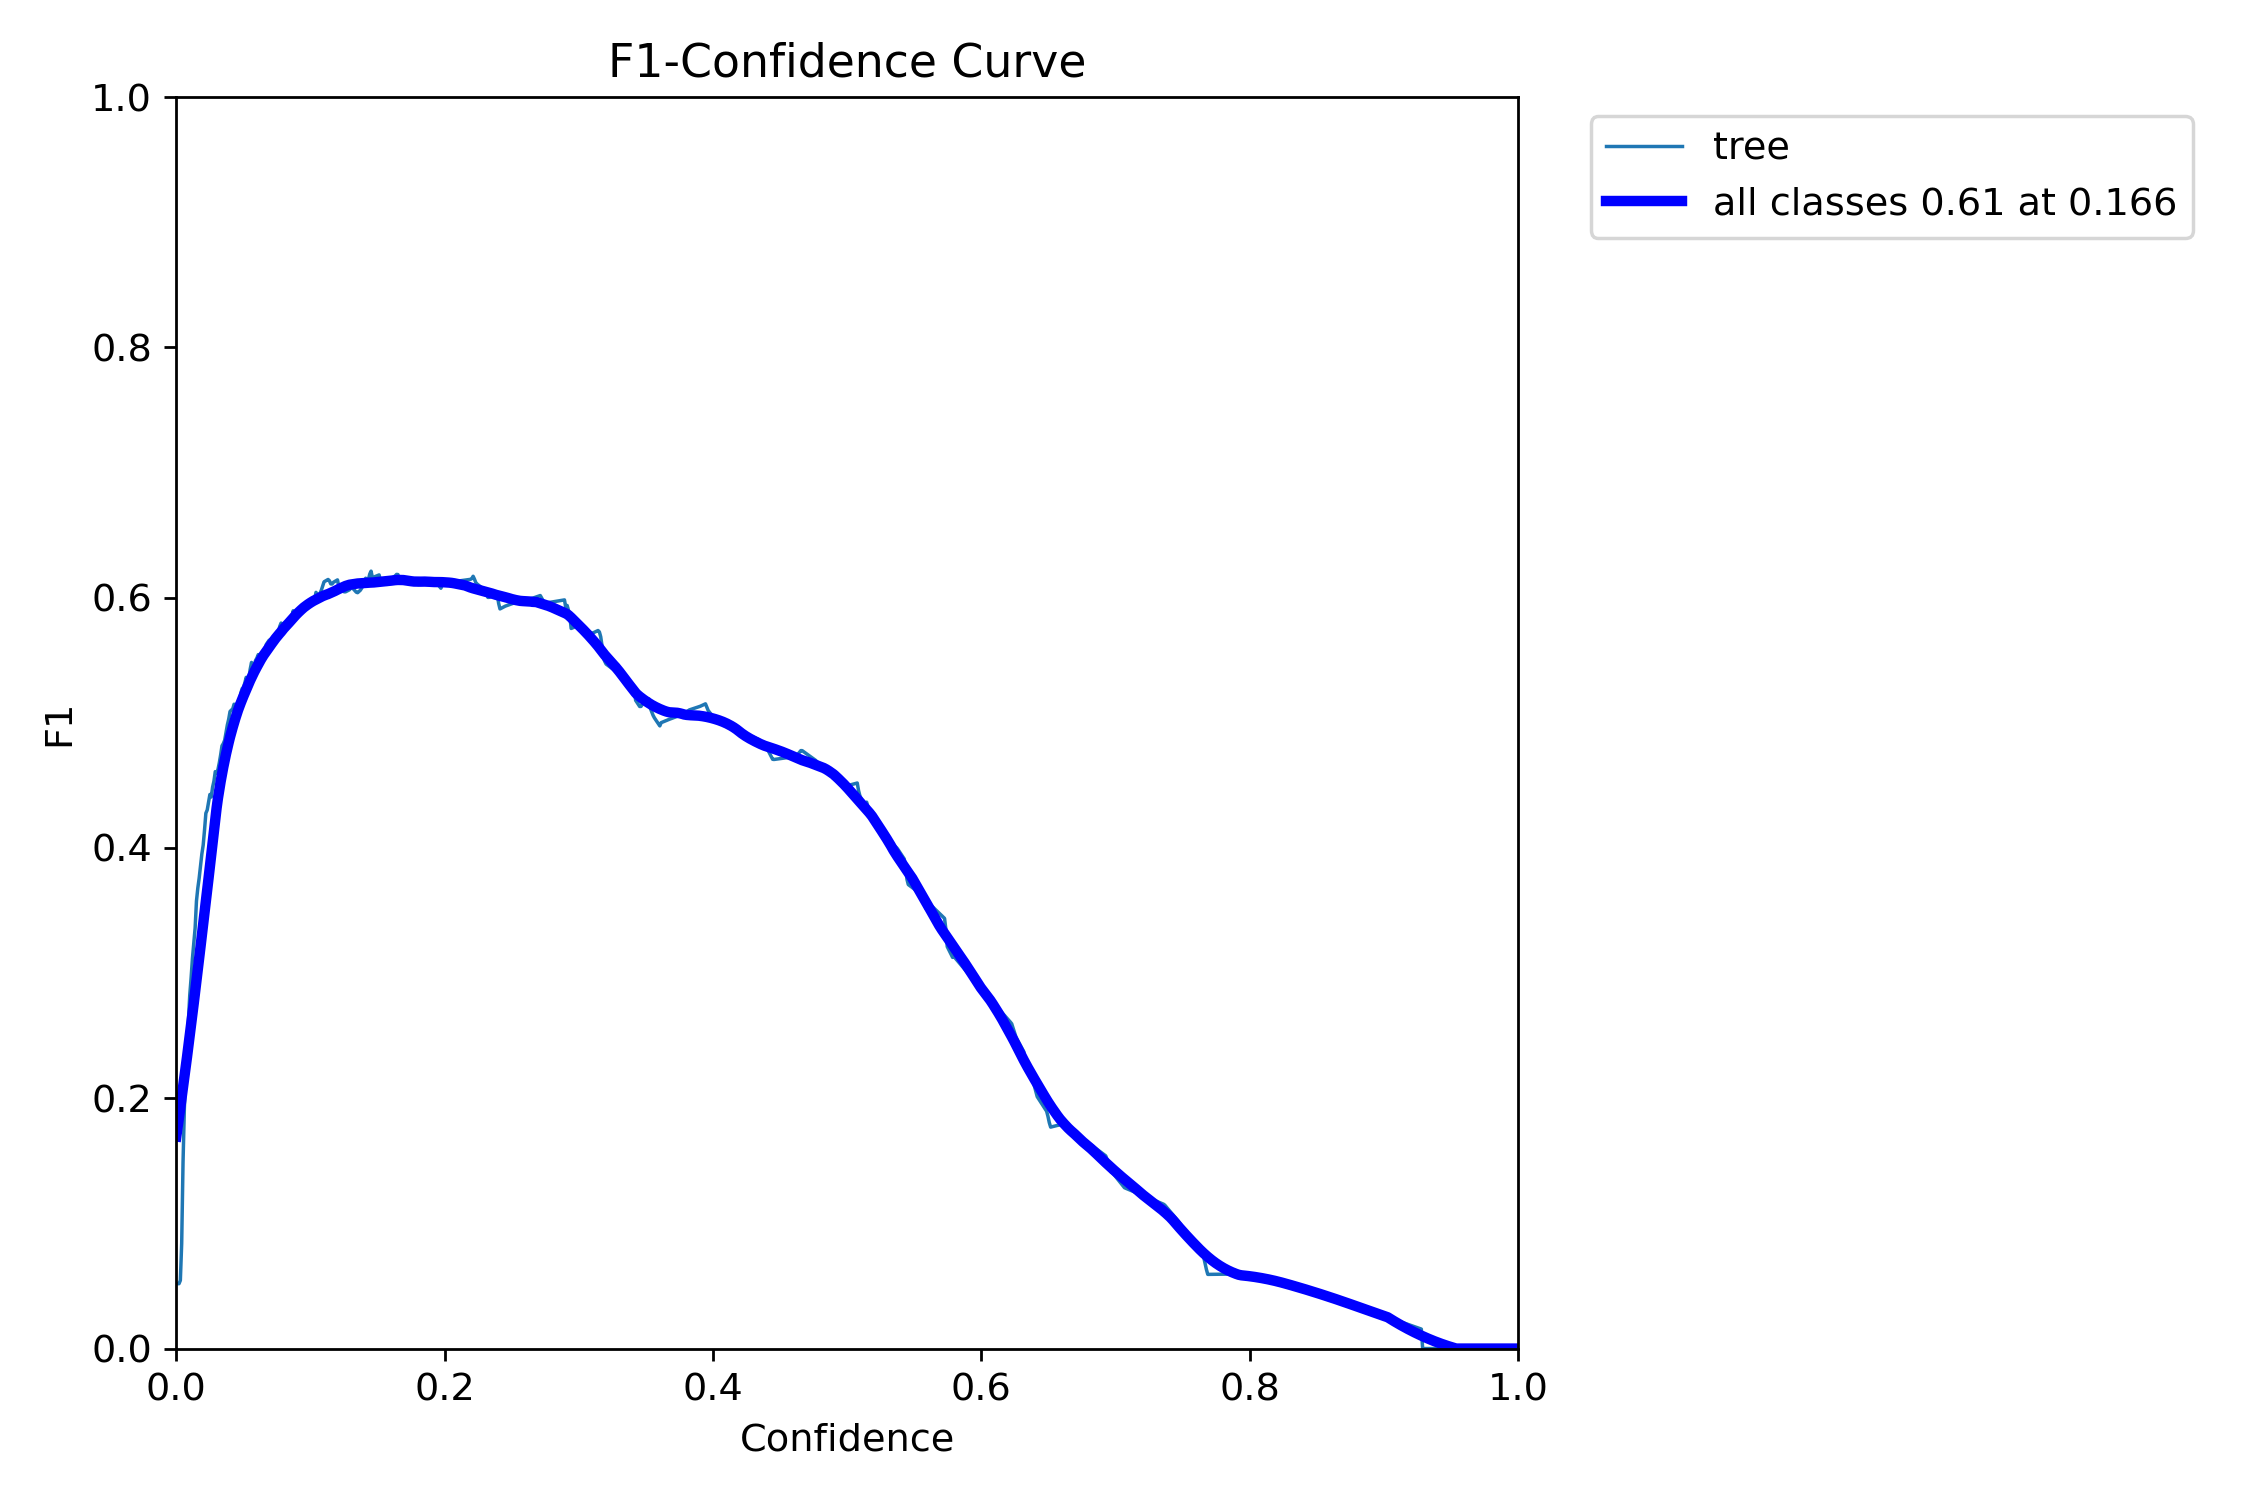

## 5.1.2. Models trained with the group's annotations


From the models trained with the full dataset, the best one according to mAP50(B) was financial_lath_8400, which corresponds to a **YOLO Nano and image size of 608**.

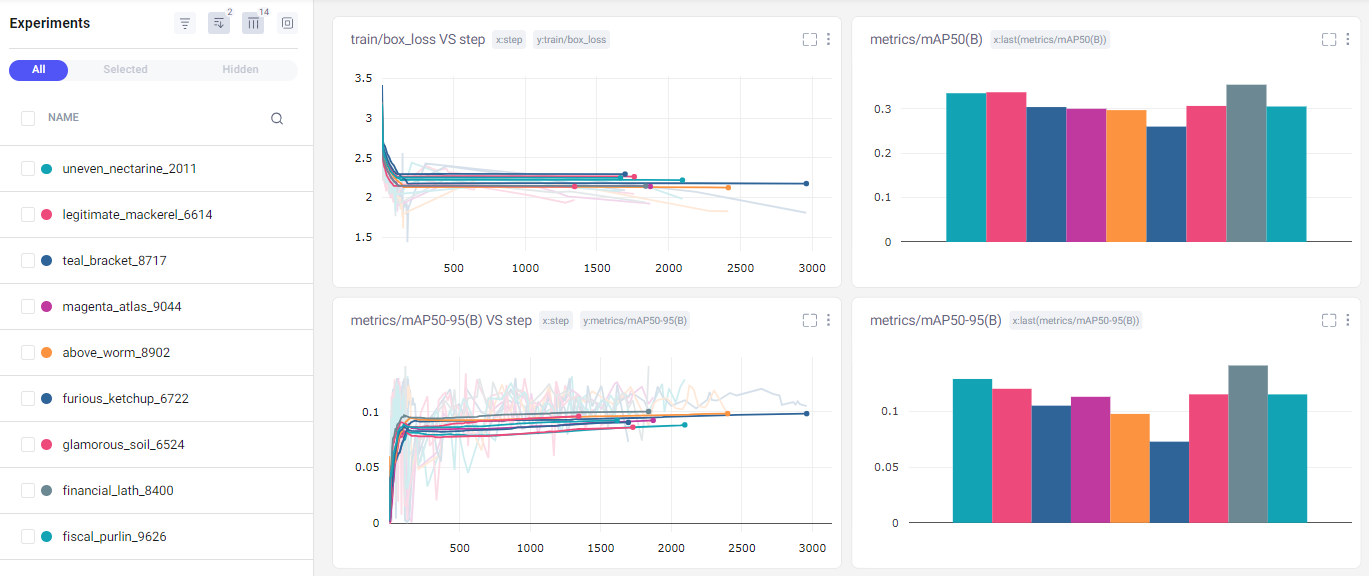

# 5.2 Setup YOLOv8 and import other libraries

In [ ]:
%pip -q install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.121 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.1/78.2 GB disk)


In [ ]:
# other libraries
!pip -q install geopandas
!pip -q install rasterio
!pip -q install folium matplotlib mapclassify
# general python packages
import os, glob, shutil
from pathlib import Path
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
#import warnings
#warnings.filterwarnings("ignore")
#import sys

# geospatial packages
from osgeo import gdal, ogr, osr
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio as rio
path_osgeo_utils= "/usr/local/lib/python3.10/dist-packages/osgeo_utils" # defines path to gdal_retile.py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 92.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 106.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 22.5 MB/s eta 0:00:00


## 5.3 Write a function to do the tiling similarly to step/scrip 1 BUT with some overlap between the tiles

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This following function tiles the orthomosaic into tiles that overlap 1 m with the adjacent ones, needed to avoid artifacts.

In [ ]:
# Params:
#   - input_ortho_path: path to orthophoto to predict on ("/content/drive/MyDrive/NOVA_course_deep_learning/data/orthomosaics/test_data/krakstad_202304_sun.tif")
#   - footprints_path: path to multipolygon layer of tile footprints ("/content/drive/MyDrive/NOVA_course_deep_learning/data/map_data/drone_acquisitions.geojson")
#   - tile_size_m: tile size in m
#   - buffer_size_m= size of overlap area around each tile in m (used for removing boundary effects)
# input_ortho_path=
# footprints_path=

def tile_orthomosaic(input_ortho_path,footprints_path, tile_size_m, buffer_size_m):
  # Define path to data
  path_data="/content/drive/MyDrive/HOME_EXAM/data"#"/content/drive/MyDrive/NOVA_course_deep_learning/data"

  # read drone acquisition footprints
  footprints= gpd.read_file(footprints_path)
  # Get ortho name
  ortho_name=os.path.splitext(os.path.basename(input_ortho_path)) [0]

  # create output dir
  output_tiles_dir=path_data+"/tiles/"+str(tile_size_m)+"m_"+ortho_name
  if not os.path.exists(output_tiles_dir):
    print("Creating output folder..."+ output_tiles_dir)
    os.makedirs(output_tiles_dir)

  # get raster metadata
  # Get pixel resolution (in meters) and tile size in pixels
  src_ds = gdal.Open(input_ortho_path) # reads in the orthomosaic
  _, xres, _, _, _, yres  = src_ds.GetGeoTransform() # get pixel size in meters
  print("Ortho resolution: "+str(round(xres,4))+" m")
  # Get EPSG code
  proj = osr.SpatialReference(wkt=src_ds.GetProjection())
  EPSG_code= proj.GetAttrValue('AUTHORITY',1)
  print("EPSG code: "+str(EPSG_code))
  # get number of bands
  n_bands=src_ds.RasterCount
  print("Number of bands: "+str(n_bands))

  # Compute tile and buffer size in pixels
  tile_size_px= round(tile_size_m/abs(xres)) # calculate the tile size in pixels
  buffer_size_px= round(buffer_size_m/abs(xres)) # calculate the buffer size in pixels
  tileIndex_name=ortho_name+"_tile_index" # define name for output tile index shapefile

  # Run gdal_retile.py using (can take some minutes)
  command_retile = "python "+path_osgeo_utils+"/gdal_retile.py -targetDir " + output_tiles_dir + " " + input_ortho_path+ " -overlap " + str(buffer_size_px) + " -ps "+str(tile_size_px) + " " + str(tile_size_px) + " -of GTiff -tileIndex "+ tileIndex_name + " -tileIndexField ID"
  print(os.popen(command_retile).read()) ################################################################### SWITCH THIS ONE FOR TILING #########################################

  # cleanup tiles
  footprint_ortho= footprints[footprints['filename']==ortho_name]
  footprint_ortho_UU= footprint_ortho.geometry.unary_union
  # Load tiles shapefile
  tiles = gpd.read_file(output_tiles_dir+ "/"+ortho_name+"_tile_index.shp")
  tiles= tiles.to_crs(EPSG_code)

  # Select all tiles that are within the boundary polygon
  tiles_in = tiles[tiles.geometry.within(footprint_ortho_UU)]

  # Select all tiles that are not within the boundary polygon
  tiles_out= tiles.loc[~tiles['ID'].isin(tiles_in['ID']) ]
  print(str(len(tiles_out))+" tiles to be deleted")

  # delete tiles that are not within the footprint
  gtiffs_delete=[output_tiles_dir+ "/"+sub  for sub in tiles_out['ID']]
  for f in gtiffs_delete:
   if os.path.exists(f):
     os.remove(f)





In [ ]:
import os

annotator_ID=20 # my folder ID

my_drive_path="/content/drive/MyDrive/HOME_EXAM/data"

#path_to_ortho_predict= my_drive_path+"/orthomosaics/test_data/galbyveien_20230504_sun.tif"
#path_to_tiles=my_drive_path+"/tiles/10m_"+str(os.path.splitext( os.path.basename(path_to_ortho_predict))[0])

path_to_ortho_predicts = []
for root, dirs, files in os.walk(my_drive_path+"/orthomosaics/test_data"):
    for file in files:
        path_to_ortho_predict = os.path.join(root, file)
        path_to_ortho_predicts.append(path_to_ortho_predict)


path_to_tiles = [my_drive_path+"/tiles/10m_" + str(os.path.splitext( os.path.basename(path_to_ortho_predict))[0]) for path_to_ortho_predict in path_to_ortho_predicts]


In [ ]:
my_drive_path+"/tiles"

'/content/drive/MyDrive/HOME_EXAM/data/tiles'

Now the function is applied to all the orthomosaics

In [ ]:
[tile_orthomosaic(path_to_ortho_predict,
                 footprints_path= "/content/drive/MyDrive/NOVA_course_deep_learning/data/map_data/drone_acquisitions.geojson",
                 tile_size_m=10, # this could be changed
                 buffer_size_m=1) # this could be changed)
                 for path_to_ortho_predict in path_to_ortho_predicts]

Ortho resolution: 0.0077 m
EPSG code: 25832
Number of bands: 4
0...10...20...30...40...50...60...70...80...90...100 - done.

333 tiles to be deleted


Ortho resolution: 0.0074 m
EPSG code: 25832
Number of bands: 4
0...10...20...30...40...50...60...70...80...90...100 - done.

261 tiles to be deleted


Ortho resolution: 0.0085 m
EPSG code: 25832
Number of bands: 4
0...10...20...30...40...50...60...70.
903 tiles to be deleted


Ortho resolution: 0.0108 m
EPSG code: 25832
Number of bands: 4
0...10...20...30...40...50...60...70...80...90...100 - done.

820 tiles to be deleted


[None, None, None, None]

Now with the test orthomosaics ready, we can apply the models.

# 5.4 Apply the models

## 5.4.1. My model

First my model. I have to check the confidence interval of my model. The figure is not the best as it should have a clear peak and in my case kind of looks like a plateau but in any case, the confidence interval should be 0,166.


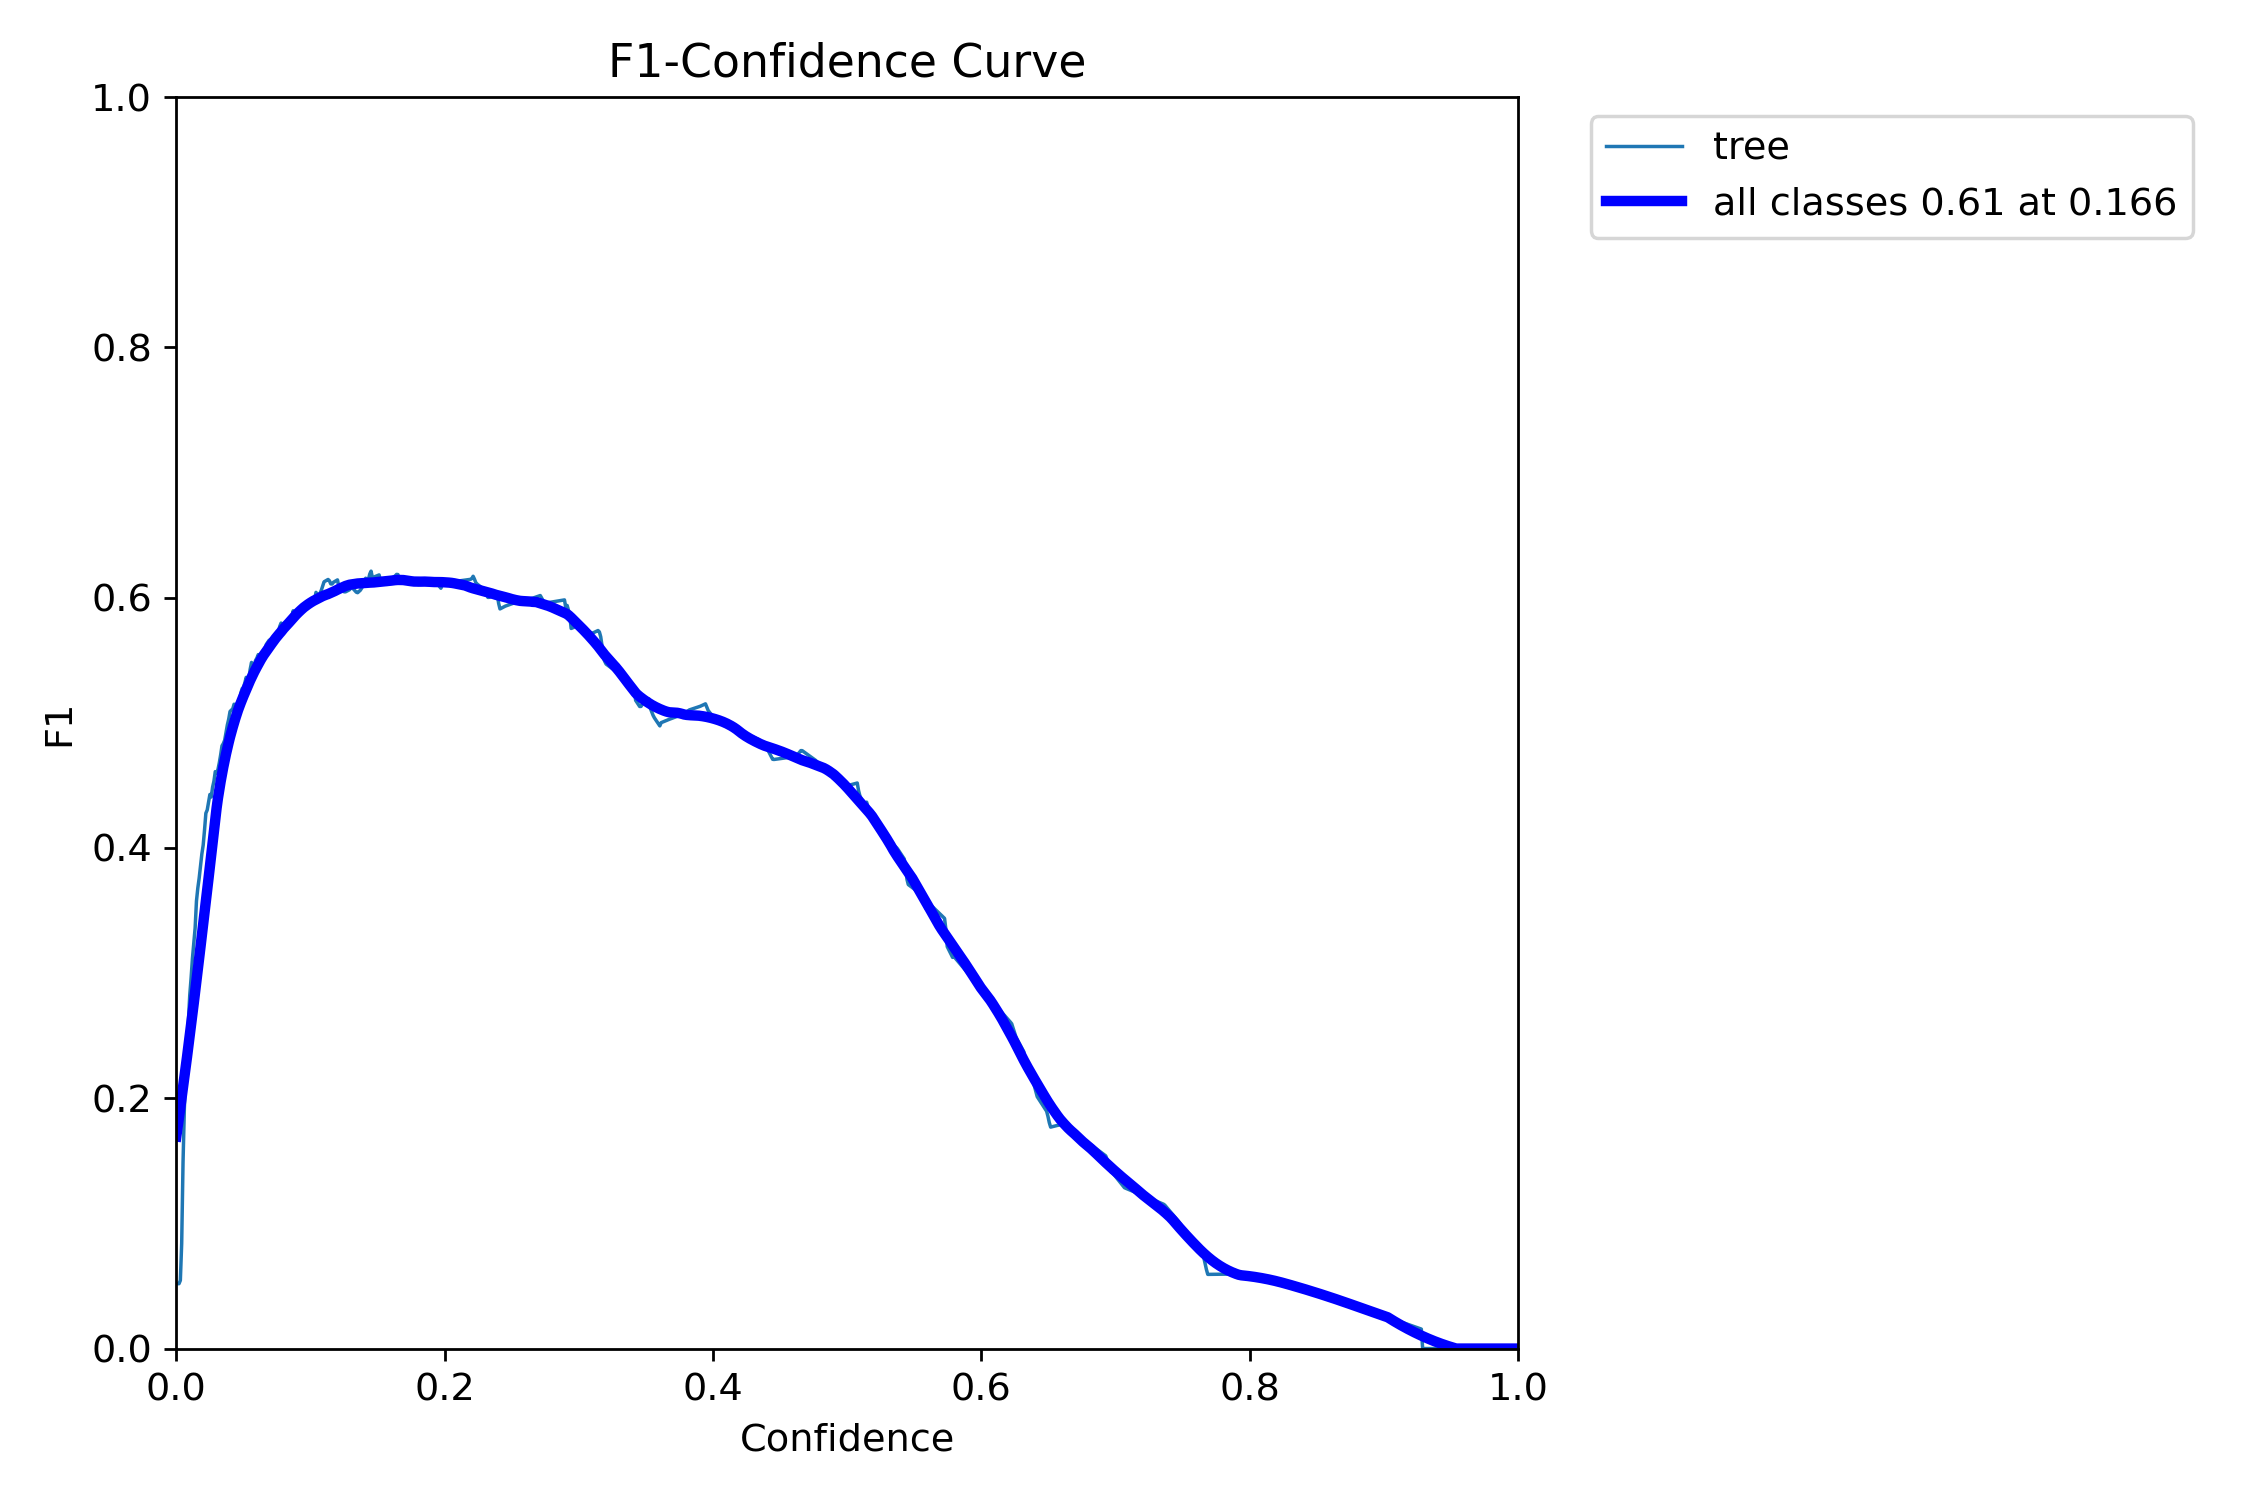

In [ ]:
path_to_model=my_drive_path+"/annotated_data/train/"+str(annotator_ID)+"/seedlingsDetection_YOLOn_img800_annotations_20/weights/best.pt"

'/content/drive/MyDrive/HOME_EXAM/data/tiles/10m_galbyveien_20230504_sun'

In [ ]:
path_to_tiles

['/content/drive/MyDrive/HOME_EXAM/data/tiles/10m_krakstad_202304_sun',
 '/content/drive/MyDrive/HOME_EXAM/data/tiles/10m_ortho_hobol_042222_mavic_sun',
 '/content/drive/MyDrive/HOME_EXAM/data/tiles/10m_braatan_40m_20230605_sun',
 '/content/drive/MyDrive/HOME_EXAM/data/tiles/10m_galbyveien_20230504_sun']

In [ ]:
for path_to_tile in path_to_tiles:
  print(path_to_tile)
  !yolo predict model=$path_to_model source=$path_to_tile imgsz=800 conf=0.166 project=$path_to_tile name=predict_tile_20 save_txt=True save_conf=True save=True line_width=1

/content/drive/MyDrive/HOME_EXAM/data/tiles/10m_krakstad_202304_sun
Ultralytics YOLOv8.0.121 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients

image 1/217 /content/drive/MyDrive/HOME_EXAM/data/tiles/10m_krakstad_202304_sun/krakstad_202304_sun_03_08.tif: 800x800 3 trees, 10.1ms
image 2/217 /content/drive/MyDrive/HOME_EXAM/data/tiles/10m_krakstad_202304_sun/krakstad_202304_sun_03_09.tif: 800x800 6 trees, 10.0ms
image 3/217 /content/drive/MyDrive/HOME_EXAM/data/tiles/10m_krakstad_202304_sun/krakstad_202304_sun_03_10.tif: 800x800 1 tree, 10.0ms
image 4/217 /content/drive/MyDrive/HOME_EXAM/data/tiles/10m_krakstad_202304_sun/krakstad_202304_sun_03_11.tif: 800x800 3 trees, 10.0ms
image 5/217 /content/drive/MyDrive/HOME_EXAM/data/tiles/10m_krakstad_202304_sun/krakstad_202304_sun_04_06.tif: 800x800 4 trees, 10.0ms
image 6/217 /content/drive/MyDrive/HOME_EXAM/data/tiles/10m_krakstad_202304_sun/krakstad_202304_sun_04

# 5.4.2. Full dataset model

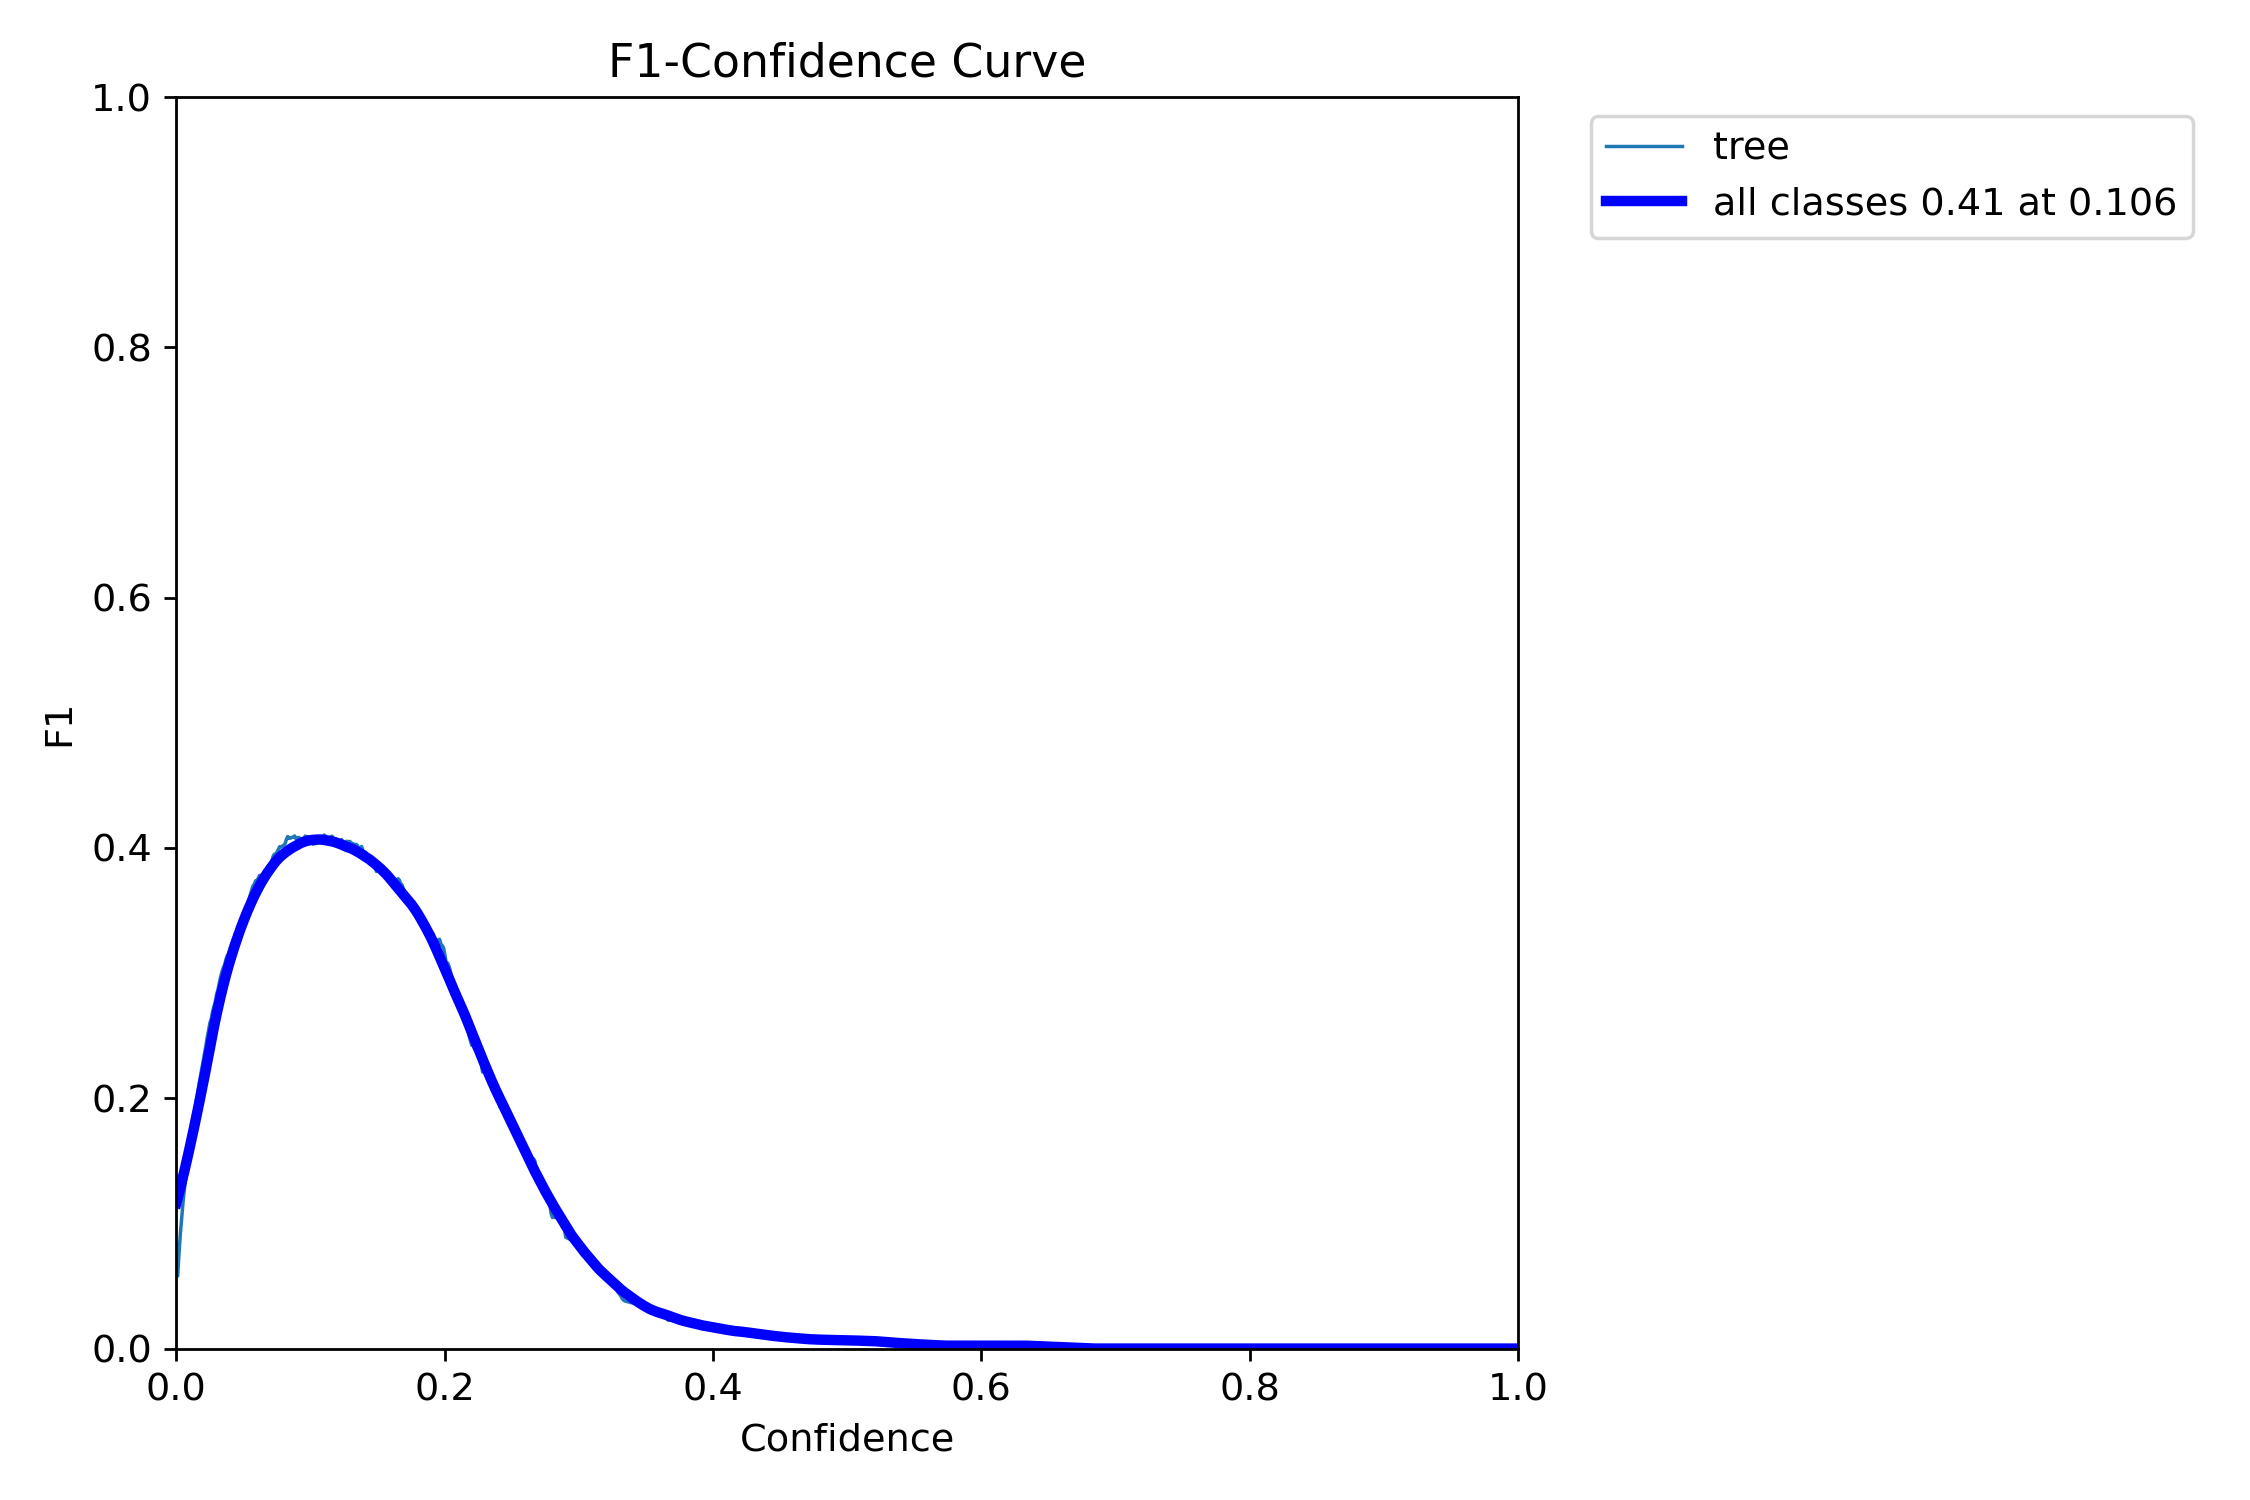

In [ ]:
path_to_model=my_drive_path+"/annotated_data/train/full_data/all_data"+"/seedlings_YOLOn_img608_annotations_full_data/weights/best.pt"
path_to_tiles


['/content/drive/MyDrive/HOME_EXAM/data/tiles/10m_krakstad_202304_sun',
 '/content/drive/MyDrive/HOME_EXAM/data/tiles/10m_ortho_hobol_042222_mavic_sun',
 '/content/drive/MyDrive/HOME_EXAM/data/tiles/10m_braatan_40m_20230605_sun',
 '/content/drive/MyDrive/HOME_EXAM/data/tiles/10m_galbyveien_20230504_sun']

In [ ]:
#!yolo predict model=$path_to_model source=$path_to_tiles imgsz=416 conf=0.264 project=$path_to_tiles name=predict_tiles save_txt=True save_conf=True save=True line_width=1
for path_to_tile in path_to_tiles:
  print(path_to_tile)
  !yolo predict model=$path_to_model source=$path_to_tile imgsz=608 conf=0.106 project=$path_to_tile name=predict_tile_full_data save_txt=True save_conf=True save=True line_width=1

/content/drive/MyDrive/HOME_EXAM/data/tiles/10m_krakstad_202304_sun
Ultralytics YOLOv8.0.121 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients

image 1/217 /content/drive/MyDrive/HOME_EXAM/data/tiles/10m_krakstad_202304_sun/krakstad_202304_sun_03_08.tif: 608x608 7 trees, 7.3ms
image 2/217 /content/drive/MyDrive/HOME_EXAM/data/tiles/10m_krakstad_202304_sun/krakstad_202304_sun_03_09.tif: 608x608 7 trees, 7.2ms
image 3/217 /content/drive/MyDrive/HOME_EXAM/data/tiles/10m_krakstad_202304_sun/krakstad_202304_sun_03_10.tif: 608x608 5 trees, 8.3ms
image 4/217 /content/drive/MyDrive/HOME_EXAM/data/tiles/10m_krakstad_202304_sun/krakstad_202304_sun_03_11.tif: 608x608 3 trees, 7.7ms
image 5/217 /content/drive/MyDrive/HOME_EXAM/data/tiles/10m_krakstad_202304_sun/krakstad_202304_sun_04_06.tif: 608x608 4 trees, 10.0ms
image 6/217 /content/drive/MyDrive/HOME_EXAM/data/tiles/10m_krakstad_202304_sun/krakstad_202304_sun_04_07